In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.HyperbandOptimiser import HyperbandOptimiser
from autotune.core.RandomOptimiser import RandomOptimiser
from autotune.core.TpeOptimiser import TpeOptimiser
from autotune.core.SigOptimiser import SigOptimiser

In [3]:
class OptimiserCollection(object):
    def __init__(self, name):
        self.name = name
        self.sequences = []
        self.t_seq = []
        self.y_seq = []
        
    def add_sequence(self, seq):
        assert seq.name == self.name, "Optimiser being added does not match collection name"
        seq.checkpoints.insert(0,0)
        seq.Y_best.insert(0,1)
        self.sequences.append(seq)
        self.aggregate_results()
    
    def aggregate_results(self):
        t_end = max([seq.checkpoints[-1] for seq in self.sequences])
        t_seq = np.linspace(0, t_end, num=250)

        y_seq = np.zeros((len(self.sequences),len(t_seq)))
        for i in range(len(self.sequences)):
            for j in range(len(t_seq)):
                y_seq[i][j] = self._value_at_time(self.sequences[i], t_seq[j])
        self.t_seq = t_seq
        self.y_seq = y_seq

    def _predecessor_t(self, checkpoints, t):
        assert checkpoints[0] == 0, "First checkpoint must be 0"
        for i in range(len(checkpoints)):
            if checkpoints[i] > t:
                return i -1
        return i 

    def _value_at_time(self, seq, t):
        time_index = self._predecessor_t(seq.checkpoints, t)
        return seq.Y_best[time_index]
    
    def summarise(self):
        data_collection = {}
        for i, seq in enumerate(self.sequences):
            label = "Run " + str(i)
            data_collection[label] = [len(seq.checkpoints), seq.checkpoints[-1], seq.Y_best[-1]]
        indices = ["# checkpoints", "Runtime (s)", "Optimum found"]
        df = pd.DataFrame(data=data_collection, index=indices)
        df['Average'] = df.mean(numeric_only=True, axis=1)
        print("Results summary for: {}".format(self.name))
        print(df.T)
        print("")
        
    def get_plot_values(self):
        return self.t_seq, np.average(self.y_seq,0), np.std(self.y_seq,0)


In [4]:
hyperband = OptimiserCollection("Hyperband")
random = OptimiserCollection("Random")
tpe = OptimiserCollection("TPE")
tpe_10 = OptimiserCollection("TPE")
sigopt = OptimiserCollection("SigOpt")
n = 5

for i in range(1,n+1):

    problem_text = "cifar_9hps_" + str(i)
    path = '/Users/signapoop/Desktop/results/' + problem_text
    os.chdir(path)
    file = open("results_new.pkl",'rb')
    object_file = pickle.load(file)
    file.close()
    
    file = open("tpe_20_results.pkl",'rb')
    object_file_2 = pickle.load(file)
    file.close()
    
    file = open("tpe_10_results.pkl",'rb')
    object_file_3 = pickle.load(file)
    file.close()
    
    file = open("results_sigopt.pkl",'rb')
    object_file_4 = pickle.load(file)
    file.close()
    
    # Unpack file
    hyperband.add_sequence(object_file[0])
    random.add_sequence(object_file[1])
    tpe.add_sequence(object_file_2[0])
    tpe_10.add_sequence(object_file_3[0])
    sigopt.add_sequence(object_file_4[0])

tpe.name = "TPE_20"
tpe_10.name = "TPE_10"
#optimisers = [hyperband, random, tpe, tpe_10]
optimisers = [hyperband, random, tpe_10, sigopt]

In [5]:
for optimiser in optimisers:
    optimiser.summarise()

Results summary for: Hyperband
         # checkpoints  Runtime (s)  Optimum found
Run 0             13.0  3975.345654        0.17510
Run 1             13.0  3838.718927        0.16720
Run 2             13.0  4195.151520        0.15110
Run 3             13.0  4082.960697        0.20500
Run 4             13.0  5094.829335        0.16240
Average           13.0  4237.401227        0.17216

Results summary for: Random
         # checkpoints  Runtime (s)  Optimum found
Run 0             25.0  7126.305975        0.19260
Run 1             31.0  7202.313896        0.20990
Run 2             28.0  7068.148471        0.18180
Run 3             27.0  7290.269904        0.16660
Run 4             28.0  7318.247680        0.20000
Average           27.8  7201.057185        0.19018

Results summary for: TPE_10
         # checkpoints   Runtime (s)  Optimum found
Run 0             31.0  10123.810000        0.17860
Run 1             31.0   9300.240000        0.15820
Run 2             31.0   9746.280000     

In [10]:
def plot_convergence(optimisers, problem_text=""):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7), dpi=200)
    lines = ['-b', '-k', '-r', '-g']
    for i, optimiser in enumerate(optimisers):
        t, y, std = optimiser.get_plot_values()
        ax.plot(t, y, lines[i], label=optimiser.name)
        ax.fill_between(t, y-std, y+std,facecolor=lines[i][1], alpha=0.2)
    
    #ax.set_ylim(0.05,0.15)
    ax.set_xlim(0,7000)
    ax.set_ylim(0.125,0.32)
    ax.grid()
    plt.ylabel('Average Min Test Error')
    plt.xlabel('Time (s)')
    plt.legend()
    
    res = ["{} min error = {:.4f}".format(opt.name, np.average(opt.y_seq[:,-1])) for opt in optimisers]
    title = problem_text + "\n" + "\n".join(res)
    plt.title(title)
    #plt.savefig(path+"/"+problem_text, dpi=200)
    plt.show()

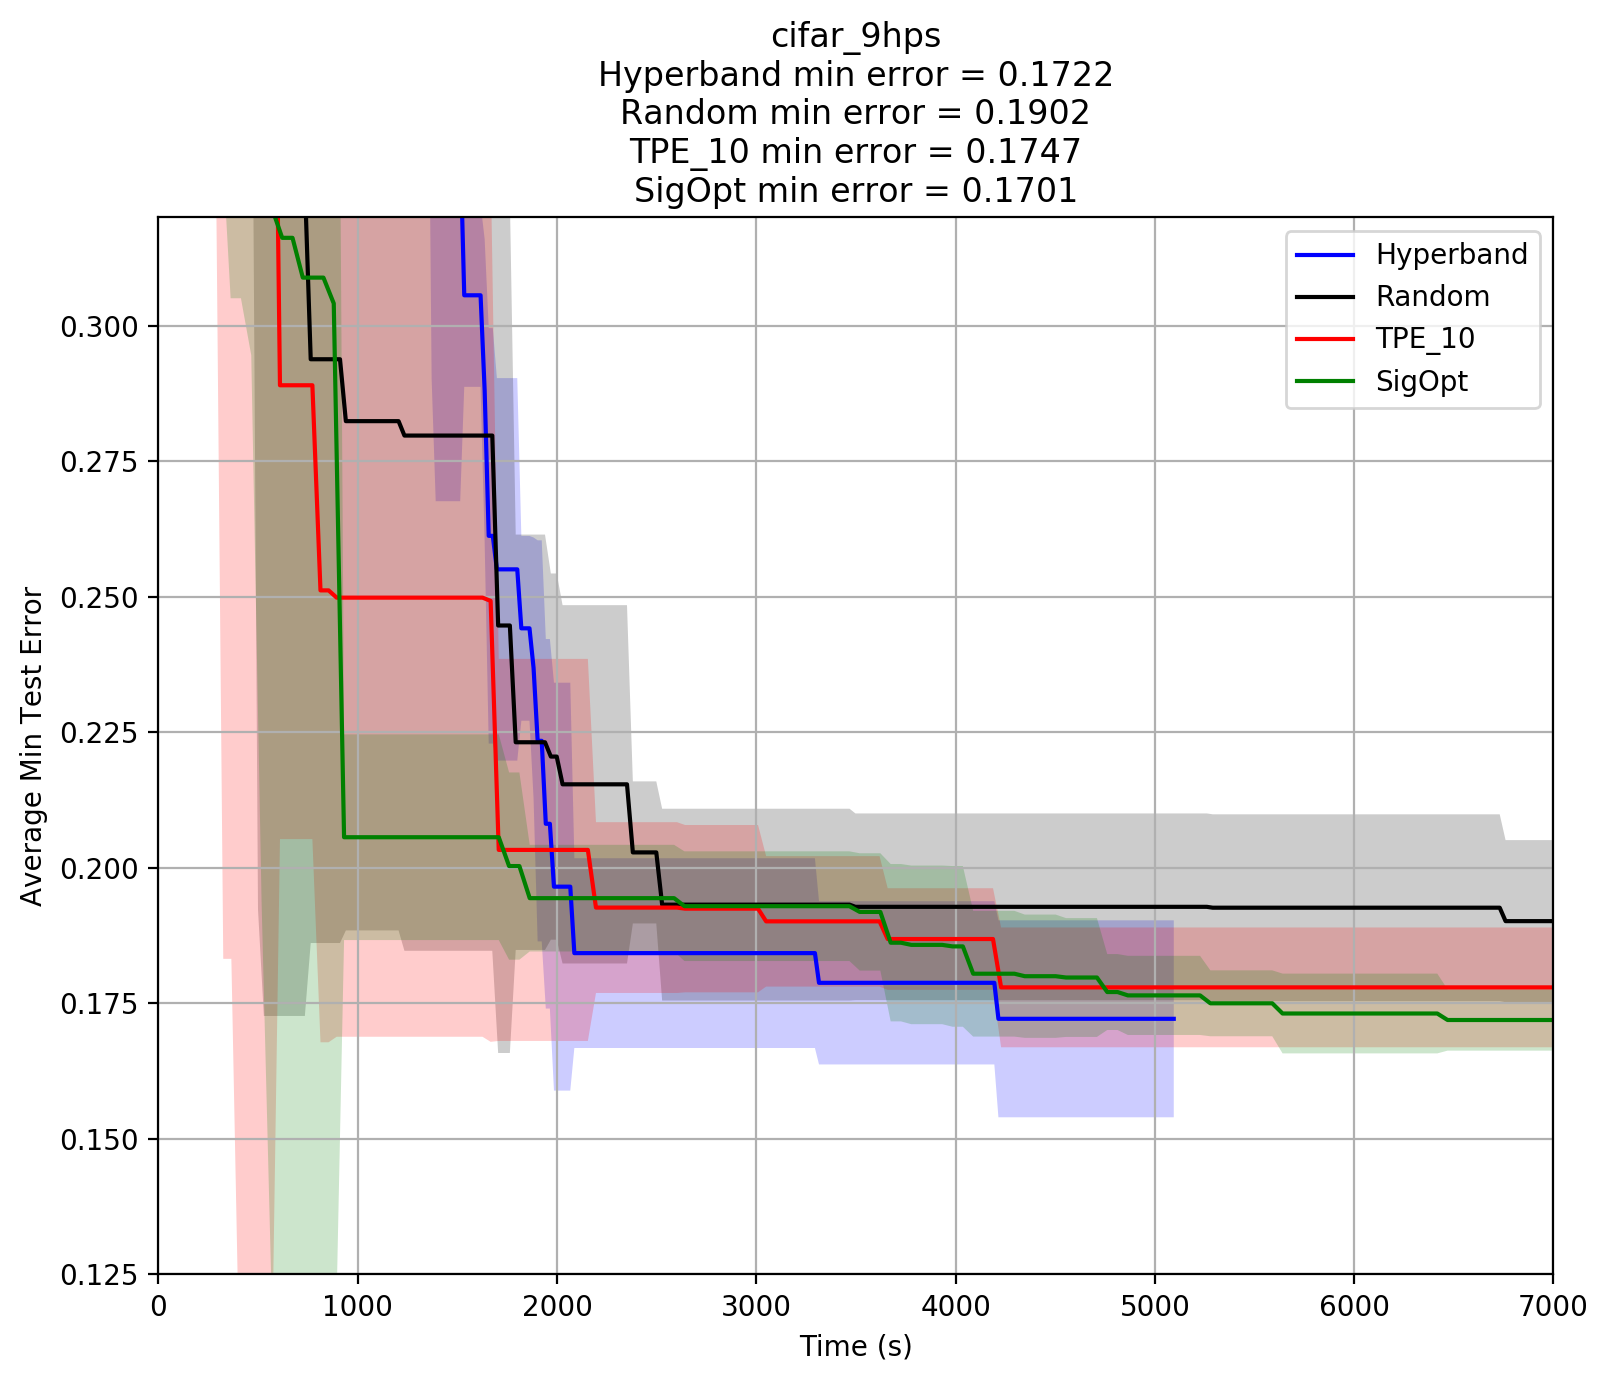

In [11]:
problem_text = "cifar_9hps"
plot_convergence(optimisers, problem_text)